In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/EmilianoHFlores/segment-anything

fatal: destination path 'segment-anything' already exists and is not an empty directory.


In [3]:
%cd segment-anything/notebooks
import os
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content/segment-anything/notebooks


In [5]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [6]:
# Model
model = torch.hub.load("ultralytics/yolov5", "yolov5x")  # or yolov5n - yolov5x6, custom

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-19 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


['groceries.jpg', 'prueba4.jpg', 'prueba2.jpg', 'foto_desktop.jpeg', 'prueba1.jpeg', 'prueba5.jpg', 'prueba3.jpg', 'truck.jpg', 'dog.jpg']


In [9]:
# Images
#img = "data/images/zidane.jpg" # or file, Path, PIL, OpenCV, numpy, list
imgPath0 = "images/prueba2.jpg"

img = cv2.imread(imgPath0)
%cd segment-anything/notebooks

[Errno 2] No such file or directory: 'segment-anything/notebooks'
/content/segment-anything/notebooks


In [10]:
results = model(img)

Predicted bottle at [892.02, 5.62, 1731.62, 1442.72, 0.94] with confidence 39.00.
Predicted cup at [2225.18, 2.25, 2697.95, 559.3, 0.92] with confidence 41.00.
Predicted tv at [665.92, 1.16, 1962.72, 434.23, 0.84] with confidence 62.00.
Predicted keyboard at [2.9, 637.01, 611.95, 969.16, 0.75] with confidence 66.00.
Predicted cup at [2732.42, 1077.3, 3309.23, 2097.69, 0.72] with confidence 41.00.
Predicted cup at [1755.08, 940.31, 2384.76, 1742.34, 0.37] with confidence 41.00.
Predicted book at [0.0, 1813.77, 1253.54, 2601.8, 0.33] with confidence 73.00.
Predicted laptop at [195.2, 0.57, 936.75, 882.52, 0.3] with confidence 63.00.
Predicted bottle at [198.58, 3.07, 934.81, 879.31, 0.29] with confidence 39.00.


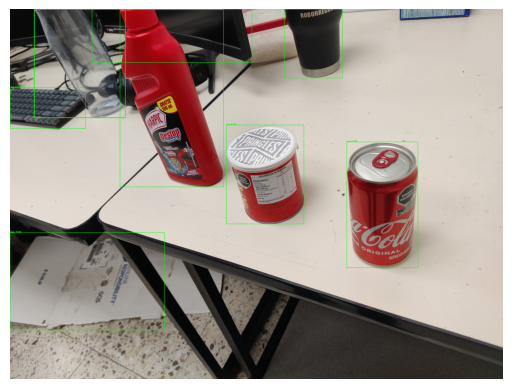

In [11]:
%matplotlib inline
# Results
showimg = img.copy()
for *xyxy, conf, cls in results.pandas().xyxy[0].itertuples(index=False):
    print(f"Predicted {cls} at {[round(elem, 2) for elem in xyxy ]} with confidence {conf:.2f}.")
    showimg = cv2.rectangle(showimg, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)
    showimg = cv2.putText(showimg, f"{cls} {conf:.2f}", (int(xyxy[0]), int(xyxy[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Visualize on matplotlib
plt.imshow(cv2.cvtColor(showimg, cv2.COLOR_BGR2RGB))
plt.axis('off') 
plt.show()

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [14]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
sam_model = "h"

if sam_model =="h":
  sam_checkpoint = "/content/segment-anything/notebooks/sam_vit_h_4b8939.pth"
  model_type = "vit_h"
else:
  sam_checkpoint = "/content/segment-anything/notebooks/sam_vit_l_0b3195.pth"
  model_type = "vit_l"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [15]:
scale_percent = 100 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

predictor.set_image(resized)

In [16]:
image_bboxes = []
image_xywh = []

for *xyxy, conf, cls in results.pandas().xyxy[0].itertuples(index=False):
  if cls in ['cup', 'bottle', 'vase'] or True:
    print(f"Predicted {cls} at {[round(elem, 2) for elem in xyxy ]} with confidence {conf:.2f}.")
    image_bboxes.append(np.array([xyxy[0], xyxy[1], xyxy[2], xyxy[3]]))
    image_xywh.append([xyxy[0], xyxy[1], xyxy[2]-xyxy[0], xyxy[3]-xyxy[1]])

masks = []

for image_bbox in image_bboxes:
  mask, _, _ = predictor.predict(
      point_coords=None,
      point_labels=None,
      box=image_bbox,
      multimask_output=False,
  )
  masks.append(mask)

Predicted bottle at [892.02, 5.62, 1731.62, 1442.72, 0.94] with confidence 39.00.
Predicted cup at [2225.18, 2.25, 2697.95, 559.3, 0.92] with confidence 41.00.
Predicted cup at [2732.42, 1077.3, 3309.23, 2097.69, 0.72] with confidence 41.00.
Predicted cup at [1755.08, 940.31, 2384.76, 1742.34, 0.37] with confidence 41.00.
Predicted bottle at [198.58, 3.07, 934.81, 879.31, 0.29] with confidence 39.00.


drawing mask0
<class 'numpy.ndarray'>
drawing mask1
<class 'numpy.ndarray'>
drawing mask2
<class 'numpy.ndarray'>
drawing mask3
<class 'numpy.ndarray'>
drawing mask4
<class 'numpy.ndarray'>
(3000, 4000)


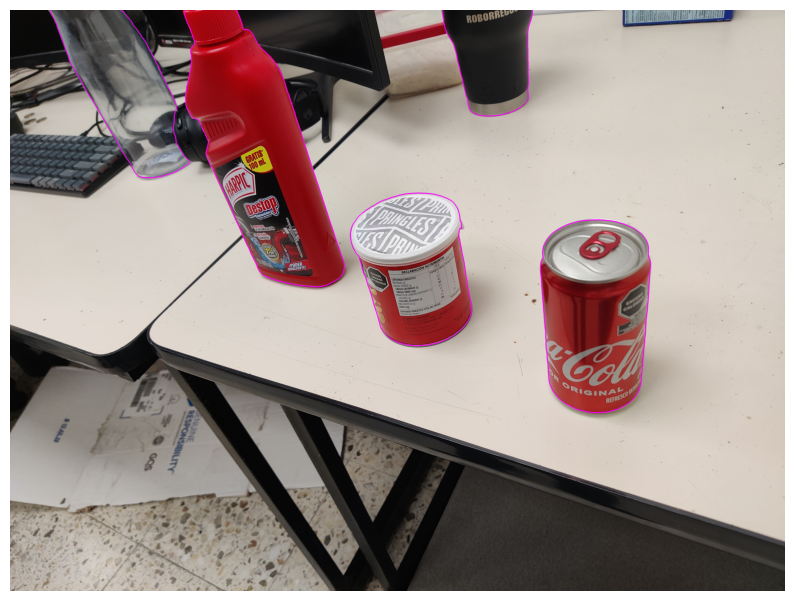

In [17]:
plt.figure(figsize=(10, 10))
showimg = resized.copy()

for i, mask in enumerate(masks):
  print(f"drawing mask{i}")
  print(type(mask[0]))
  contours, _ = cv2.findContours(mask[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(showimg, contours, -1, (255,0,255), 3)



plt.imshow(cv2.cvtColor(showimg, cv2.COLOR_BGR2RGB))

print(masks[0].shape[-2:])
plt.axis('off')
plt.show()

['groceries.jpg', 'prueba4.jpg', 'prueba2.jpg', 'prueba5.jpg', '.ipynb_checkpoints', 'prueba3.jpg', 'truck.jpg']
Processing image: groceries.jpg
Imgid: 0
Finished image groceries.jpg


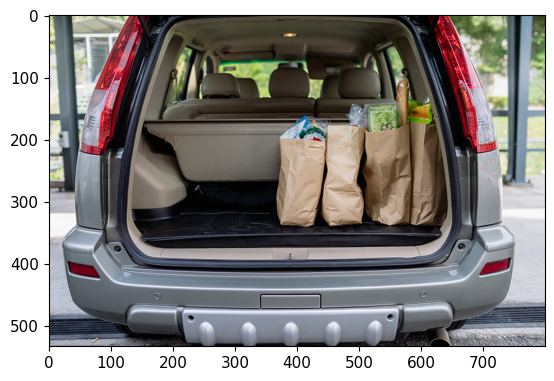

Processing image: prueba4.jpg
Predicted bottle at [141.31, 197.24, 1185.22, 2199.52, 0.94] with on img prueba4.jpg.
Predicted cup at [2645.61, 1253.25, 3272.61, 2134.77, 0.86] with on img prueba4.jpg.
Predicted bottle at [748.01, 2.48, 1328.51, 975.59, 0.82] with on img prueba4.jpg.
Predicted cup at [1589.98, 1338.47, 2225.33, 2208.11, 0.71] with on img prueba4.jpg.
Imgid: 1
Finished image prueba4.jpg


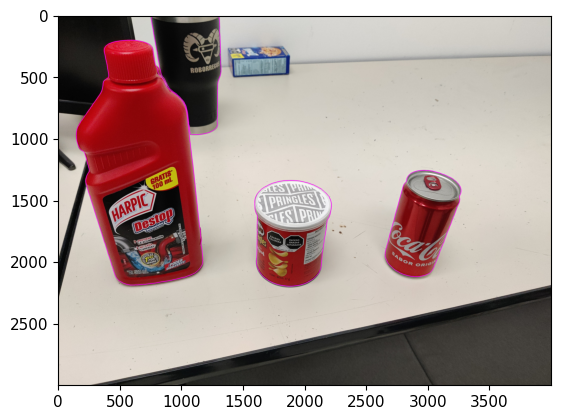

Processing image: prueba2.jpg
Predicted bottle at [892.02, 5.62, 1731.62, 1442.72, 0.94] with on img prueba2.jpg.
Predicted cup at [2225.18, 2.25, 2697.95, 559.3, 0.92] with on img prueba2.jpg.
Predicted cup at [2732.42, 1077.3, 3309.23, 2097.69, 0.72] with on img prueba2.jpg.
Predicted cup at [1755.08, 940.31, 2384.76, 1742.34, 0.37] with on img prueba2.jpg.
Predicted bottle at [198.58, 3.07, 934.81, 879.31, 0.29] with on img prueba2.jpg.
Imgid: 2
Finished image prueba2.jpg


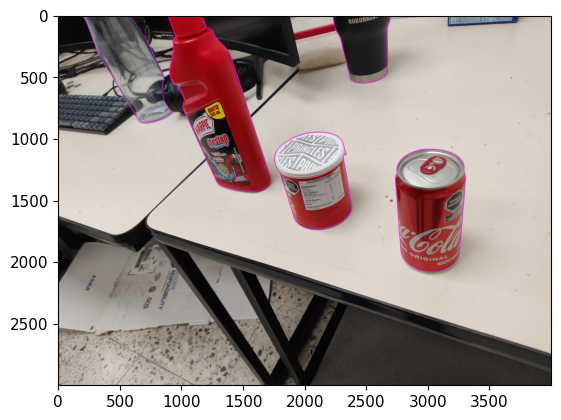

Processing image: prueba5.jpg
Predicted bottle at [656.54, 991.51, 1563.91, 1984.89, 0.92] with on img prueba5.jpg.
Predicted cup at [1275.84, 2.88, 1847.73, 657.22, 0.82] with on img prueba5.jpg.
Predicted cup at [2717.69, 1575.69, 3187.49, 2181.6, 0.76] with on img prueba5.jpg.
Imgid: 3
Finished image prueba5.jpg


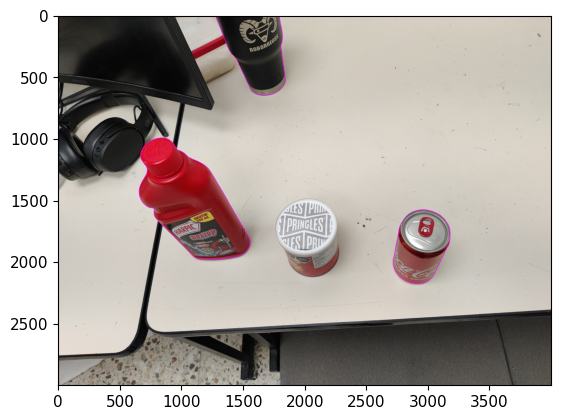

Processing image: .ipynb_checkpoints
Processing image: prueba3.jpg
Predicted bottle at [303.85, 448.37, 1275.91, 2636.32, 0.92] with on img prueba3.jpg.
Predicted cup at [3.24, 65.92, 652.19, 1199.91, 0.86] with on img prueba3.jpg.
Imgid: 4
Finished image prueba3.jpg


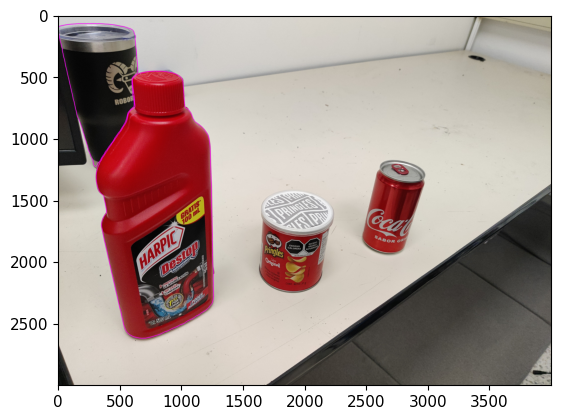

Processing image: truck.jpg
Imgid: 5
Finished image truck.jpg


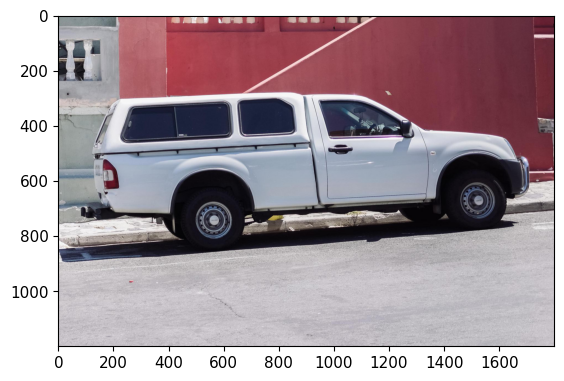

[{'id': 0, 'image_id': 1, 'category_id': 0, 'bbox': [141, 197, 1043, 2002], 'segmentation': [585, 203, 584, 204, 560, 204, 559, 205, 542, 205, 541, 206, 529, 206, 528, 207, 518, 207, 517, 208, 509, 208, 508, 209, 502, 209, 501, 210, 496, 210, 495, 211, 490, 211, 489, 212, 483, 212, 482, 213, 477, 213, 476, 214, 471, 214, 470, 215, 465, 215, 464, 216, 460, 216, 459, 217, 457, 217, 456, 218, 453, 218, 452, 219, 450, 219, 449, 220, 447, 220, 446, 221, 444, 221, 443, 222, 440, 222, 439, 223, 437, 223, 436, 224, 434, 224, 433, 225, 432, 225, 431, 226, 430, 226, 429, 227, 427, 227, 426, 228, 424, 228, 423, 229, 422, 229, 421, 230, 419, 230, 418, 231, 416, 231, 415, 232, 414, 232, 413, 233, 411, 233, 409, 235, 408, 235, 405, 238, 404, 238, 401, 241, 400, 241, 397, 244, 396, 244, 394, 246, 393, 246, 388, 251, 388, 252, 386, 254, 386, 255, 385, 256, 385, 257, 383, 259, 383, 260, 380, 263, 380, 264, 378, 266, 378, 267, 377, 268, 377, 270, 376, 271, 376, 273, 375, 274, 375, 284, 374, 285, 374, 29

'\n    for img in fg_imgs:\n        fg_img=img[1]\n\n        # Load the image with alpha channel\n        image = cv2.imread(img[2], cv2.IMREAD_UNCHANGED)\n\n        # Extract the alpha channel and convert it to a binary mask\n        alpha = image[:,:,3]\n        mask = alpha > 0\n\n        # Find contours and polygonal approximations\n        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\n\n        # Format the segmentation coordinates in COCO format\n        segmentation = []\n        aux_segmentation = []\n        for contour in contours:\n            polygon = contour.flatten().tolist()\n            if len(polygon) % 2 != 0:\n                print("Error: polygon has an odd number of coordinates")\n                continue\n            polygon = np.array(polygon).reshape((-1, 2))\n            aux_segmentation.append(polygon)\n        polygon_area = cv2.contourArea(aux_segmentation[0])\n        for sublist in aux_segmentation[0]:\

In [82]:
# Creating annotation in COCO format
#{"id": 0, "file_name": "0.jpg", "height": 480, "width": 736}
images=[]
annotations=[]
categories=[]

category_id = 0
category_name = "laptop"

image_0 ={"id": 0, "file_name": "0.jpg", "height": 480, "width": 736}

img_id=0
anno_id=0

imgPaths = os.listdir('images')
print(imgPaths)

for imgPath in imgPaths:
  print(f"Processing image: {imgPath}")
  img = cv2.imread(f"images/{imgPath}")
  if img is None:
    continue
  results = model(img)

  image_bboxes = []
  xywh = []

  #Get yolo results
  for *xyxy, conf, cls in results.pandas().xyxy[0].itertuples(index=False):
    #run for each detection
    if cls in ['cup', 'bottle', 'vase']:
      print(f"Predicted {cls} at {[round(elem, 2) for elem in xyxy ]} with on img {imgPath}.")
      image_bbox = (np.array([xyxy[0], xyxy[1], xyxy[2], xyxy[3]]))
      xywh = [xyxy[0], xyxy[1], xyxy[2]-xyxy[0], xyxy[3]-xyxy[1]]

      predictor.set_image(img)
  
      mask, _, _ = predictor.predict(
          point_coords=None,
          point_labels=None,
          box=image_bbox,
          multimask_output=False,
      )

      contours, _ = cv2.findContours(mask[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cv2.drawContours(img, contours, -1, (255,0,255), 3)

      segmentation = []
      aux_segmentation = []
      for contour in contours:
        polygon = contour.flatten().tolist()
        if len(polygon) % 2 != 0:
            print("Error: polygon has an odd number of coordinates")
            continue
        polygon = np.array(polygon).reshape((-1, 2))
        aux_segmentation.append(polygon)
      polygon_area = int(cv2.contourArea(aux_segmentation[0]))

      for sublist in aux_segmentation[0]:
        for item in sublist:
          segmentation.append(int(item))
      
      annotations.append({"id": anno_id,"image_id": img_id,"category_id": category_id,"bbox": [int(xywh[0]), int(xywh[1]), int(xywh[2]), int(xywh[3])],"segmentation": segmentation,"area": polygon_area,"iscrowd": 0})
      anno_id = anno_id+1
  print(f"Imgid: {img_id}")
  images.append({"id": img_id, "file_name": imgPath,"height": img.shape[0],"width": img.shape[1]})
  img_id = img_id+1
  print(f"Finished image {imgPath}")

  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

categories = []
categories.append({"id": 0,"name": "red bottles"})
print(annotations)
  



#--------------------------------------------------
'''
    for img in fg_imgs:
        fg_img=img[1]

        # Load the image with alpha channel
        image = cv2.imread(img[2], cv2.IMREAD_UNCHANGED)

        # Extract the alpha channel and convert it to a binary mask
        alpha = image[:,:,3]
        mask = alpha > 0

        # Find contours and polygonal approximations
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Format the segmentation coordinates in COCO format
        segmentation = []
        aux_segmentation = []
        for contour in contours:
            polygon = contour.flatten().tolist()
            if len(polygon) % 2 != 0:
                print("Error: polygon has an odd number of coordinates")
                continue
            polygon = np.array(polygon).reshape((-1, 2))
            aux_segmentation.append(polygon)
        polygon_area = cv2.contourArea(aux_segmentation[0])
        for sublist in aux_segmentation[0]:
            for item in sublist:
                segmentation.append(item)


        # Calculate the maximum allowed position for the top-left corner
        max_x = bg_img.width - fg_img.width
        max_y = bg_img.height - fg_img.height
        max_area = fg_img.width * fg_img.height

            # Generate a random location until an unoccupied area is found that meets the overlap limit

        for i in range (10):
            x = random.randint(0, max_x)
            y = random.randint(0, max_y)

            # Calculate the overlap area
            overlap_area = np.sum(occupied[y:y+fg_img.height, x:x+fg_img.width])

            # Check if the area is unoccupied and the overlap limit is not exceeded
            if (max_overlap_area - max_area) >= np.sum(occupied):
                break
            if i==10:
                continue

        for i in range(0, len(segmentation)):
            if i % 2:
                i=i+x
            else :
                i=i+y
                
        # Update the occupied array
        occupied[y:y+fg_img.height, x:x+fg_img.width] = 1
        bg_img.paste(fg_img, (x, y), fg_img)
        annotations.append({"id": anno_id,"image_id": img_id,"category_id": annotations_dict[img[0]],"bbox": [x, y, fg_img.width, fg_img.height],"segmentation": segmentation,"area": polygon_area,"iscrowd": 0})
        anno_id=anno_id+1
        #draw = ImageDraw.Draw(bg_img)
        #draw.rectangle((x, y, x+fg_img.width, y+fg_img.height), outline='red', width=3)
    bg_img.save(str(img_id)+".jpg", quality=100)
    images.append({"id": img_id, "file_name": str(img_id)+".jpg","height": bg_img.height,"width": bg_img.width})
    img_id=img_id+1

    annotations.append({"id": anno_id,"image_id": img_id,"category_id": annotations_dict[img[0]],"bbox": [x, y, fg_img.width, fg_img.height],"segmentation": segmentation,"area": area,"iscrowd": 0})

    '''

In [84]:
# Define the COCO dictionary
coco_dict = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}

In [85]:
print(coco_dict)

{'images': [{'id': 0, 'file_name': 'groceries.jpg', 'height': 534, 'width': 800}, {'id': 1, 'file_name': 'prueba4.jpg', 'height': 3000, 'width': 4000}, {'id': 2, 'file_name': 'prueba2.jpg', 'height': 3000, 'width': 4000}, {'id': 3, 'file_name': 'prueba5.jpg', 'height': 3000, 'width': 4000}, {'id': 4, 'file_name': 'prueba3.jpg', 'height': 3000, 'width': 4000}, {'id': 5, 'file_name': 'truck.jpg', 'height': 1200, 'width': 1800}], 'annotations': [{'id': 0, 'image_id': 1, 'category_id': 0, 'bbox': [141, 197, 1043, 2002], 'segmentation': [585, 203, 584, 204, 560, 204, 559, 205, 542, 205, 541, 206, 529, 206, 528, 207, 518, 207, 517, 208, 509, 208, 508, 209, 502, 209, 501, 210, 496, 210, 495, 211, 490, 211, 489, 212, 483, 212, 482, 213, 477, 213, 476, 214, 471, 214, 470, 215, 465, 215, 464, 216, 460, 216, 459, 217, 457, 217, 456, 218, 453, 218, 452, 219, 450, 219, 449, 220, 447, 220, 446, 221, 444, 221, 443, 222, 440, 222, 439, 223, 437, 223, 436, 224, 434, 224, 433, 225, 432, 225, 431, 226, 4

In [86]:
import json
json_annotation = json.dumps(coco_dict)
with open('annotations.json', 'w') as f:
  f.write(json_annotation)

In [87]:
!cat annotations.json

{"images": [{"id": 0, "file_name": "groceries.jpg", "height": 534, "width": 800}, {"id": 1, "file_name": "prueba4.jpg", "height": 3000, "width": 4000}, {"id": 2, "file_name": "prueba2.jpg", "height": 3000, "width": 4000}, {"id": 3, "file_name": "prueba5.jpg", "height": 3000, "width": 4000}, {"id": 4, "file_name": "prueba3.jpg", "height": 3000, "width": 4000}, {"id": 5, "file_name": "truck.jpg", "height": 1200, "width": 1800}], "annotations": [{"id": 0, "image_id": 1, "category_id": 0, "bbox": [141, 197, 1043, 2002], "segmentation": [585, 203, 584, 204, 560, 204, 559, 205, 542, 205, 541, 206, 529, 206, 528, 207, 518, 207, 517, 208, 509, 208, 508, 209, 502, 209, 501, 210, 496, 210, 495, 211, 490, 211, 489, 212, 483, 212, 482, 213, 477, 213, 476, 214, 471, 214, 470, 215, 465, 215, 464, 216, 460, 216, 459, 217, 457, 217, 456, 218, 453, 218, 452, 219, 450, 219, 449, 220, 447, 220, 446, 221, 444, 221, 443, 222, 440, 222, 439, 223, 437, 223, 436, 224, 434, 224, 433, 225, 432, 225, 431, 226, 4

In [88]:
# Download the file.
from google.colab import files
files.download('annotations.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>